# MoE Scaling Laws: Experimental Validation

This notebook implements, demonstrates, and validates the theoretical scaling laws presented in: [_"Novel Scaling Laws for MoE Architectures: A Theoretical Analysis"_](https://github.com/wrmedford/moe-scaling) by Wes Medford, et al.

## Experimental assumptions:

This experiment makes a few assumptions based on real-world hardware:

| Parameter          | Simulated Value | Typical Real-World Equivalent |
|---------------------|-----------------|-------------------------------|
| Cache Size          | 32MB            | L3 Cache on modern CPU/GPU    |
| Bus Bandwidth       | 0.5GB/s         | PCIe 4.0 x16 link             |
| Cache Bandwidth     | 4GB/s           | GDDR6/X memory bandwidth      |

**Note**: the line charts shown use a logorithmic scale

In [1]:
# Import local script in scaling.py
from scaling import *

# Import notebook dependencies
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# system config for experimental system:
# adjust to show different scaling distributions.
system_config = SystemConfig(
    # 32MB cache
    cache_size=1024 * 1024 * 32,
    
    # 0.5 GB/s
    bus_bandwidth=1024 * 1024 * 1024 * 0.5,
    
    # 4 GB/s
    cache_bandwidth=1024 * 1024 * 1024 * 4,
    
    # 100ns
    cache_hit_latency=1e-7,
    
    # 10μs
    cache_miss_latency=1e-5,
)

simulator = ScalingLawSimulator(system_config)
runner = ExperimentRunner(simulator)
visualizer = Visualizer()

## Experiment 1: Expert Count Scaling

This experiment validates the relationship between expert count and cache efficiency

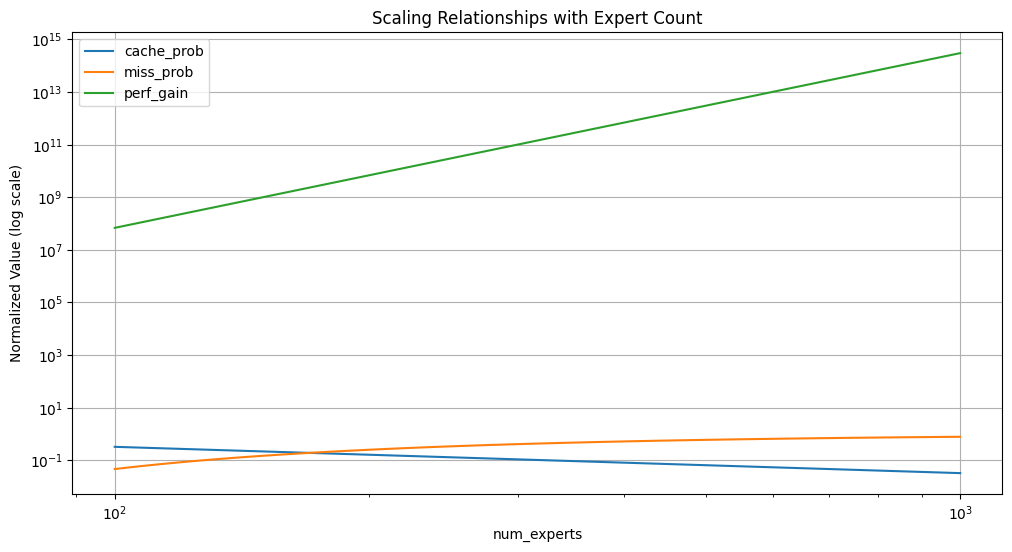

In [3]:
results_count = runner.expert_count_sweep(
    start_experts=100,
    end_experts=1000,
    step=100,
    expert_size=1024 * 1024,  # 1MB per expert
    experts_per_forward=8,
)

visualizer.plot_scaling_relationships(
    results_count,
    "num_experts",
    ["cache_prob", "miss_prob", "perf_gain"],
    "Scaling Relationships with Expert Count",
)

As the theoretical performance gains increase as the number of experts increase, there exists a sweet spot where the cache "miss" probability crosses over with the moe caching probability. This demonstrates the proposed relationship between expert count, expert size, and the cache effeciency rate.

## Experiment 2: Expert Size Scaling

This experiment examines how expert size affects system performance

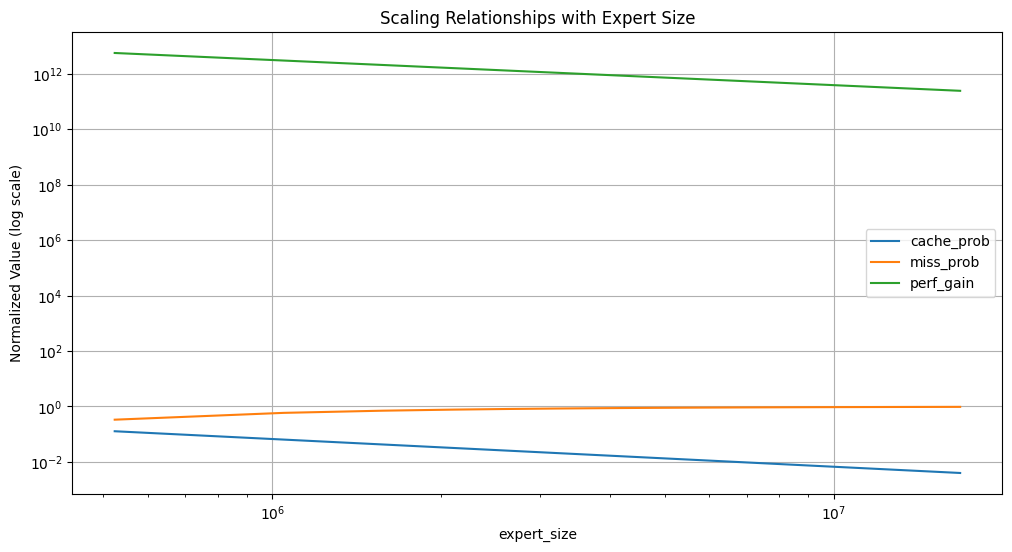

In [4]:
results_size = runner.expert_size_sweep(
    num_experts=500,
    start_size=1024 * 512,  # 512KB
    end_size=1024 * 1024 * 16,  # 16MB
    step=1024 * 512,  # 512KB steps
    experts_per_forward=8,
)

visualizer.plot_scaling_relationships(
    results_size,
    "expert_size",
    ["cache_prob", "miss_prob", "perf_gain"],
    "Scaling Relationships with Expert Size",
)

As expert size increases, note the theoretical decrease in performance gains and the decrease in caching capabilities: cache miss rate remains relatively logarithmically stable.

## Experiment 3: Performance Contour Analysis

This experiment aims to show the relationship between expert count,
size, and performance gain across all 3 dimensions.

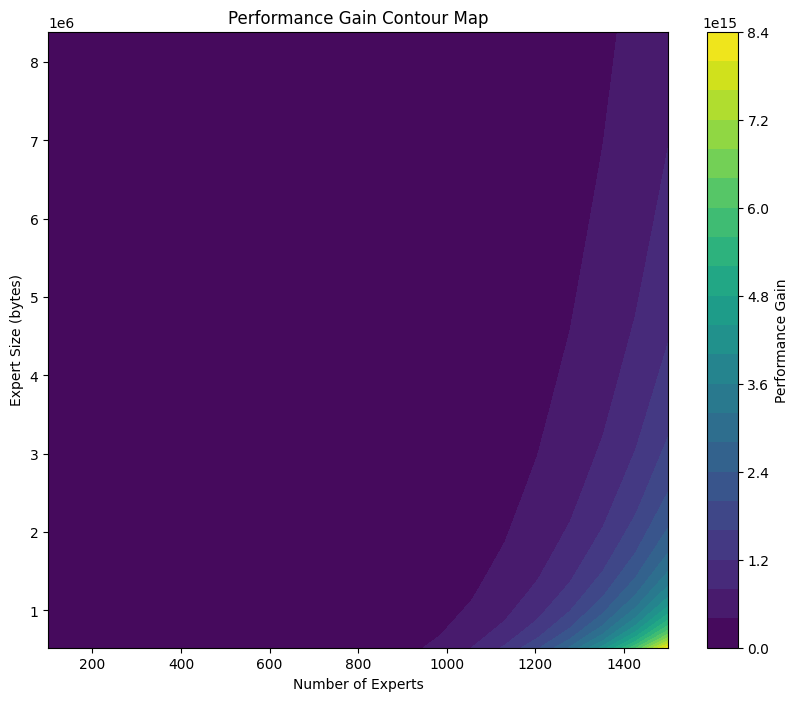

In [8]:
# Parameter ranges for number of experts:
# from 100 to 1500 experts in steps of 20.
num_experts_range = np.linspace(100, 1500, 20)

# Parameter range for the size of experts:
# start with 512KB and go up to 8MB.
# Use 512KB steps.
expert_sizes_range = np.linspace(1024 * 512, 1024 * 1024 * 8, 1024 * 512)

# Calculate performance matrix
perf_matrix = np.zeros((len(expert_sizes_range), len(num_experts_range)))
for i, size in enumerate(expert_sizes_range):
    for j, num_experts in enumerate(num_experts_range):
        config = MoEConfig(int(num_experts), int(size), 8)
        perf_matrix[i, j] = simulator.calculate_performance_gain(config)

# Plot contour graph
visualizer.plot_performance_contour(
    num_experts_range, expert_sizes_range, perf_matrix, "Performance Gain Contour Map"
)

Note that beginning around 1000 small experts, performance caching performance gains are realized. Performance gains continue for small expert sizes given the proposed scaling law.

# Analysis

This demonstrates a few key principles proposed by Wes Medford, et al:

1. Cache efficiency improves with increased expert count, following the predicted exponential relationship
2. Expert size has an inverse relationship with performance, as predicted by the β scaling factor
3. The contour map reveals optimal configurations balancing expert count and size

#### Custom Experiments

You can modify the parameters above to explore different scenarios:

- Adjust system configuration parameters to match different hardware
- Change expert counts and sizes to match your model architecture
- Modify experts_per_forward to reflect different routing strategies